# Ice Velocity Data

> This page is a Jupyter Notebook that can be [found and downloaded at the GitHub repository](https://github.com/trchudley/geospatial-python-durham/blob/main/website/03_data/02_ice_velocity.ipynb).

In [42]:
import requests, json

import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import box
from typing import Literal, Optional, Union


## Downloading ITS_LIVE mosaic datasets

The ITS_LIVE mosaic data is hosted on AWS as a series of cloud-optimised GeoTIFFs. Simply find the link to the `.tif` file you want [using the ITS_LIVE GUI](https://nsidc.org/apps/itslive/) and you feed it straight into rioxarray! These are large files so I would recommend applying an AOI - that's what cloud-optimised data are good for.

Here is a litte function that constructs the file you want for V2 data:

In [19]:

def get_itslive_fpath(
    composite: Optional[bool] = False, 
    year: Optional[Union[str, int]] = None,
    variable: Optional[Literal["v", "vx", "vy", "v_error", "vx_error", "vy_error", "count"]] = "v",
    ) -> str:
    """
    Get a filepath to a V2 ITS_LIVE mosaic dataset. Must have either composite 
    set to True for the full mosaic, or provide a year.
    """

    if composite == False and year is None:
        raise ValueError("You must set either composite to True or provide a year.")

    if variable not in ["v", "vx", "vy", "v_error", "vx_error", "vy_error", "count"]:
        raise ValueError("variable must be one of 'v', 'vx', 'vy', 'v_error', 'vx_error', 'vy_error', 'count'")

    if composite == True:
        return f"https://its-live-data.s3.amazonaws.com/velocity_mosaic/v2/static/cog/ITS_LIVE_velocity_120m_RGI05A_0000_v02_{variable}.tif"

    else:
        return f"https://its-live-data.s3.amazonaws.com/velocity_mosaic/v2/annual/cog/ITS_LIVE_velocity_120m_RGI05A_{year}_v02_{variable}.tif"


Now we can load some data and display it. I'm going to download both the magnitude data `v` and the vector `vx` and `vy` data so I can show an example of making a simple flow diagram.

The data is in polar stereographic, so I will provide a bounding box accordingly.

In [24]:
vv_fpath = get_itslive_fpath(composite=True, variable="v")
vx_fpath = get_itslive_fpath(composite=True, variable="vx")
vy_fpath = get_itslive_fpath(composite=True, variable="vy")

kangerlussuaq_bounds = 465000, -2300000, 496000, -2258000

vv = rxr.open_rasterio(vv_fpath).rio.clip_box(*kangerlussuaq_bounds).squeeze().compute()
vx = rxr.open_rasterio(vx_fpath).rio.clip_box(*kangerlussuaq_bounds).squeeze().compute()
vy = rxr.open_rasterio(vy_fpath).rio.clip_box(*kangerlussuaq_bounds).squeeze().compute()

We can easily visualise the velocity field. The composite feild extends into the fjord because of mélange coherence.

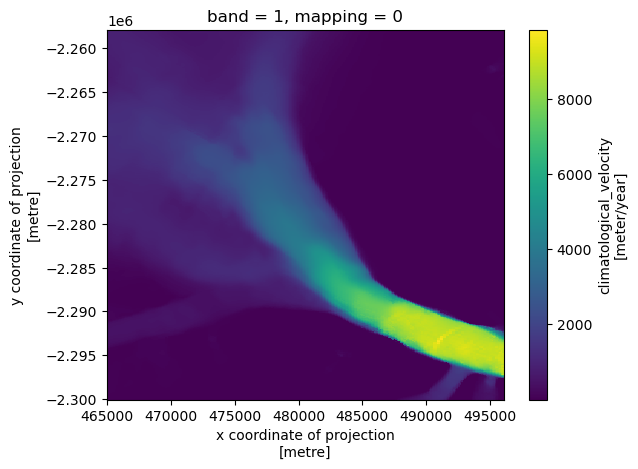

In [17]:
vv.plot.imshow()

Let's make a nice figure:

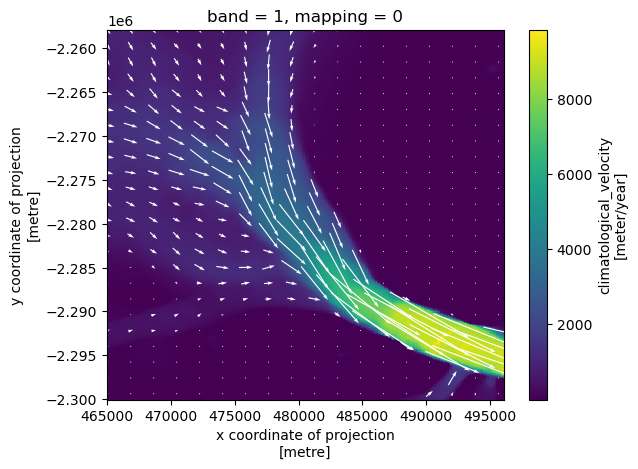

In [33]:
fig, ax = plt.subplots()

vv.plot.imshow(ax=ax)


show_every = 15  # Show flow direction every n pixels
skip = slice(None, None, show_every)

ax.quiver(
    vv.x.values[skip],
    vv.y.values[skip],
    vx.values[skip, skip],
    vy.values[skip, skip],
    color='white',
    pivot='mid'
)


plt.show()

Cool!

## Download Batch Data (the ITS_LIVE `zarr` file)

ITS_LIVE also make individual scene-pairs available through cloud datasets. Unfortunately, it isn't quite as neat as the STAC system, but I've put together a relatively hacky way of doing things.

The ITS_LIVE data is split into a series of square ROIs (datacubes) across Greenland. First, we must establish which datacube we need. ITS_LIVE hosts a `json` catalog of all possible cubes, which can be loaded using geopandas and clipped to your ROI with geopandas.

In [40]:

# generate AOI geodataframe
kangerlussuaq_bounds = 465000, -2300000, 496000, -2258000
aoi_gdf = gpd.GeoDataFrame(
    geometry=[box(*kangerlussuaq_bounds)], crs=3413
)

# load its_live dataset
itslive_url = (
    "https://its-live-data.s3-us-west-2.amazonaws.com/datacubes/catalog_v02.json"
)

with requests.get(itslive_url, stream=True) as response:

    # Check if the request was successful
    if response.status_code == 200:

        json_data = response.text  # Read the JSON data from the response
        data = json.loads(json_data)  # Parse the JSON data into a Python dictionary
        # print(data.keys())

        # Create GeoDataFrame from features
        if data["type"] == "FeatureCollection":
            catalog_gdf = gpd.GeoDataFrame.from_features(data["features"], crs=4326)
        else:
            print("Error: Not a GeoJSON FeatureCollection")

    else:
        print(
            f"Error: Could not retrieve data from URL. Status code: {response.status_code}"
        )

catalog_gdf = catalog_gdf.to_crs(3413)

# clip catalog to AOI
catalog_gdf = catalog_gdf.clip(aoi_gdf)

catalog_gdf



geometry  fill-opacity fill  \
1422  POLYGON ((465000 -2300000, 465000 -2258000, 49...           0.0  red   

      roi_percent_coverage                                      geometry_epsg  \
1422                 100.0  {'type': 'Polygon', 'coordinates': [[[400000, ...   

      datacube_exist                                           zarr_url  epsg  \
1422               1  http://its-live-data.s3.amazonaws.com/datacube...  3413   

      granule_count  
1422          77932

This is good news! There is only one intersecting zarr file. There is a chance your data could be split across datacubes - this becomes a bit of a pain, and one of the easiest solutions I've found it, sadly, to download them both in parallel and stitch two seperate files together when needed. Anyway, now we can simply open the zarr file as an xarray.

In [46]:
zarr_url = catalog_gdf.zarr_url.values[0]
datacube = xr.open_dataset(zarr_url, chunks='auto')

/var/folders/h7/6y8bw0210l5fp4pyvbtkx54r0000gn/T/ipykernel_54245/1836833705.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datacube = xr.open_dataset(zarr_url, chunks='auto')


In [ ]:
datacube

<xarray.Dataset> Size: 2TB
Dimensions:                     (mid_date: 80832, y: 833, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 647kB 2022-01-11T02...
  * x                           (x) float64 7kB 4.001e+05 4.003e+05 ... 5e+05
  * y                           (y) float64 7kB -2.2e+06 -2.2e+06 ... -2.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 224GB dask.array<chunksize=(40000, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 323kB dask.array<chunksize=(80832,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 224GB dask.array<chunksize=(40000, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 323kB dask.array<chunksize=(80832,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] 647kB dask.array<chunksize=(80832,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] 647kB dask.array<chunksize=(80832,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 323kB dask.array<chunksize=(80832,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 323kB dask.array<chunksize=(80832,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 323kB dask.array<chunksize=(80832,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 323kB dask.array<chunksize=(80832,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 323kB dask.array<chunksize=(80832,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 323kB dask.array<chunksize=(80832,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               03-Oct-2023 04:39:28
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2-updated-octob...
    skipped_granules:           s3://its-live-data/datacubes/v2-updated-octob...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

As you can see, we now have an xarray dataset with dimensions `x`, `y`, and `mid_date`. There's a huge amount of data variables and it's worth stripping this down before downloading anything - explicitly select only variables you understand and want. You might wish to filter by `mid_date`, `date_dt`, etc. etc.

## Calculate Derivative Strain Rates

[I have a further Python package `strain_tools`](github.com/trchudley/glacier-strain-tools) (NB: this may not be public yet) which enables you to conveniently calculate strain rates from `vx` and `vy` data. Documentation is available at the repo.